## Virtual Environment for Individual-Based Modeling

### Advanced Project I

Created on March 31, 2019 by Ralph Florent <r.florent@jacobs-university.de>

#### Description
WIP...

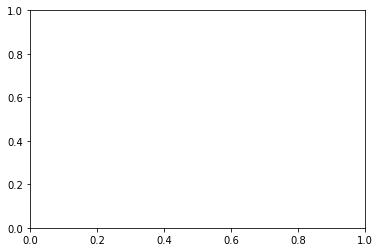

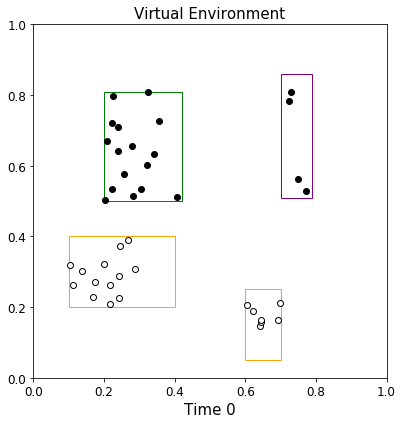

In [24]:
""" Individual-Based Modeling """

# -*- coding: utf-8 -*-
# 
# Created on March 31, 2019
# Authors: Ralph Florent <r.florent@jacobs-university.de>

### START: scripts

# Import relevant libraries
import numpy as np # arithmetic computations
import imageio as gm # gif maker
import matplotlib.pyplot as plt # plotter
import matplotlib.patches as Patches
from matplotlib.path import Path 

""" Global Default Variables """
# Path variables
MAIN_DIRECTORY = '../../dist/'
FILEPATH = MAIN_DIRECTORY + 'frame/'

# Miscellaneous variables
IMAGE_STORAGE = []  # images to become gif
PROCESSING_TIME = 0 # time for the procedure

# Matplotlib Patches variables
HABITAT_1A_VERTICES = [
    (0.10, 0.20), # left, bottom
    (0.10, 0.40), # left, top
    (0.40, 0.40), # right, top
    (0.40, 0.20), # right, bottom
    (0.10, 0.40)  # ignored (end of polyline)
]
HABITAT_1B_VERTICES = [(0.60, 0.05), (0.60, 0.25), (0.70, 0.25), (0.70, 0.05), (0.60, 0.05)]
HABITAT_2_VERTICES = [(0.70, 0.51), (0.70, 0.86), (0.79, 0.86), (0.79, 0.51), (0.70, 0.51)]
HABITAT_3_VERTICES = [(0.20, 0.50), (0.20, 0.81), (0.42, 0.81), (0.42, 0.50), (0.20, 0.50)]
HUMAN_STM_VERTICES = [(0.20, 0.50), (0.20, 0.81), (0.42, 0.81), (0.42, 0.50), (0.20, 0.50)]

# Total of Agents
TOTAL_LONG_LEGGED_SEABIRDS  = 20
TOTAL_SHORT_LEGGED_SEABIRDS = 20

# Seabird can use certain habitats
LONG_LEGGED_SEABIRD_HABITAT_LIMIT  = ['one', 'two', 'three']
SHORT_LEGGED_SEABIRD_HABITAT_LIMIT = ['one']

# The movement of the birds is driven by the probability
LONG_LEGGED_SEABIRD_HABITAT_PROB  = 0.1
SHORT_LEGGED_SEABIRD_HABITAT_PROB = 0.1


# Initial conditions
# Random so far


# Class definition for agent (seabirds)
class Agent:
    pass # On-the-fly properties

# Class definition for the habitats
class Habitat:
    def __init__(self, _type, verts, color='orange', props=None):
        self.type  = _type
        self.verts = verts
        self.color = color
        self.props = props
        
        self.codes = [
            Path.MOVETO, # start polycurve here
            Path.LINETO, # draw line to
            Path.LINETO, # draw line to 
            Path.LINETO, # draw line to
            Path.CLOSEPOLY,# finish polycurve here
        ]
        self.artist = None
        
    
    def build(self, color=None, fill=False):
        """ Create a set of patches within a specific area 
        ref: https://matplotlib.org/users/path_tutorial.html
        """
        ec = color if color is not None else self.color
        path = Path(self.verts, self.codes)
        self.artist = Patches.PathPatch(path, ec=color, fill=fill)
        return self.artist
    
    
    def contains_point(self, point):
        """ Check if a point belongs to this specific patch"""
        path = self.artist.get_path()
        return path.contains_point(point)
    
    
    def contains_points(self, points):
        """ Check if a set of points belongs to this specific patch"""
        path = self.artist.get_path()
        return path.contains_points(points)
    
    
    def count_points(self, points):
        counter = 0
        for point in points:
            if contains_point(self, point):
                counter += 1
        return counter


TOTAL_AGENTS = 20 # Seabirds 
images = [] # images to become gif
t = 0


def create_patches():
    global habitats
    habitats = []
        
    # prepare static (patch-based) habitats    
    habitats.append( Habitat('one', HABITAT_1A_VERTICES, 'orange') )
    habitats.append( Habitat('one', HABITAT_1B_VERTICES, 'orange') )
    habitats.append( Habitat('two', HABITAT_2_VERTICES, 'purple') )
    habitats.append( Habitat('three', HABITAT_3_VERTICES, 'green') )
    
    # then build artist for habitats
    for h in habitats:
        h.build()
    
    return habitats


def gen_rand_point(habitats, option=None):
    """ Generate random point that belongs (or not) to a set of patches 
    
    Parameters
    ----------
    patches: array of objects <matplotlib.patch>
        a set of patches (polycurve) to draw simple and compound outlines 
        consisting of line segments and splines.
        
    option: str = {'in', 'out', None}, default = None
            determine whether conditioning the random point being generated
            within or out of the patches. If not specified, return just 
            random points without considering the patches.
     
    Returns
    -------
    (x, y): tuple, of shape (x_coord, y_coord)
        a vertex of unit rectangle from (0,0) to (1,1).
    """
    # Make single element iterable
    habitats = habitats if isinstance(habitats, list) else [habitats]
    
    # initialize random point(x, y) by generating an array
    # of 2 random values between 0 and 1: [0.1..., 0.4...]
    x, y = np.random.rand(2)
    
    # flag up a condition to assess points within, or out of the patches
    if option == 'in':
        condition = lambda f: f
    elif option == 'out':
        condition = lambda f: not f
    else:
        return (x, y)
    
    # iterate until the point based on the given condition is found
    while True:
        found = False
        for habitat in habitats:
            if habitat.contains_point((x, y)):
                found = True
        
        # base condition to fulfill requirements
        if condition(found):
            break
        
        # update point(x, y)
        x, y = np.random.rand(2)
            
    return (x, y)



# create agents
def create_agents():
    global habitats, agents
    agents = []
    
    # build patches for short- and long-legged seabirds
    short_legged_habitat = habitats[0:2]
    long_legged_habitat  = habitats[2:4]
    
    for i in range(TOTAL_SHORT_LEGGED_SEABIRDS + TOTAL_LONG_LEGGED_SEABIRDS):
        ag = Agent()
        
        if i < TOTAL_SHORT_LEGGED_SEABIRDS:
            ag.type = 'short-legged'
            ag.x, ag.y = gen_rand_point(short_legged_habitat, 'in')
        else:
            ag.type = 'long-legged'
            ag.x, ag.y = gen_rand_point(long_legged_habitat, 'in')
            
        agents.append(ag) # store in-memory agents
    
    return agents


def initialize():
    create_patches()
    create_agents()

    
def observe():
    """ Create and plot figure """
    global patches
    global agents
    plt.cla()
   
    fig = plt.figure(figsize=(11, 6.5)) # define figure size 11x6.5 inches
    ax  = fig.add_subplot(111)
    
    for p in patches:
        ax.add_patch(p) # add artists to display rectangles
    
    # distribute agents according their types
    short = [ag for ag in agents if ag.type == 'short-legged'] # short legs
    long = [ag for ag in agents if ag.type == 'long-legged'] # long legs

    # plot agents' positions
    ax.plot([ag.x for ag in short], [ag.y for ag in short], 'o', mfc = 'w', mec = 'k')
    ax.plot([ag.x for ag in long], [ag.y for ag in long], 'o', mfc = 'k', mec = 'k')
    
    # additional settings for the graph
    plt.axis('image')
    plt.axis([0, 1, 0, 1])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Time ' + str(int(t)), fontsize=15) # Identify which image is plotted
    plt.title('Virtual Environment', fontsize=15) # Title the graph
    plt.show()
    
#     image_path = path + str(int(t)) + '.png'
#     plt.savefig(image_path, bbox_inches='tight', pad_inches=0)
#     plt.close(fig)
    
#     # storing image for final gif
#     image = gm.imread(image_path)
#     images.append(image)


def update():
    # Cannot put single artist in more than one figure
    patches = create_patches() 
    # patches for short and long legs seabirds
    sh_patches = [patches[0], patches[1]]
    lg_pathes  = [patches[2], patches[3]]
    
    global agents
    # randomly choose an agent to update its status, 
    # simplest aproach for asynchronous update: lack of resources
    ag = agents[np.random.randint(len(agents))]
    
    # simulating random movements
    """ Algorithm to move agents
    0) given a selected agent
    1) generate a new random position within the available patches
    2) move agent if the new position falls into a patch that has 
        available resources, otherwise, recompute new position that
        comply with resourceful patches.
    
    PS: New positions can be same as selected agent's initial position.
    Random selection is made with replacement. ie same agent can be 
    selected repeatedly.
    Resource availability: maximum number of agents in patches
    """
    if ag.type == 's':
        _x, _y = gen_rand_point_in(sh_patches)
        
        # agent is moving within the same area
        if is_in_patch(sh_patches[1], (ag.x, ag.y)): # resourceless patch
            # this agent belongs to the small patch, therefore he can move anywhere
            ag.x, ag.y = _x, _y
        else: # agent coming from long patch
            if is_in_patch(sh_patches[0], (_x, _y)): # moving within the same is fine
                ag.x, ag.y = _x, _y
            else:
                # moving to small patch requires resource availability checks
                short_pos = [(ag.x, ag.y) for ag in agents if ag.type == 's']
                count = count_points(sh_patches[1], short_pos)
                if count < 5: # limit so far
                    ag.x, ag.y = _x, _y
    
    # the long leg seabirds
    else:
        _x, _y = gen_rand_point_in(lg_pathes)
        
        # agent is moving within the same area
        if is_in_patch(lg_pathes[0], (ag.x, ag.y)): # resourceless patch
            # this agent belongs to the small patch, therefore he can move anywhere
            ag.x, ag.y = _x, _y
        else: # agent coming from long patch
            if is_in_patch(lg_pathes[1], (_x, _y)): # moving within the same is fine
                ag.x, ag.y = _x, _y
            else:
                # moving to small patch requires resource availability checks
                pos = [(ag.x, ag.y) for ag in agents if ag.type == 'l']
                count = count_points(lg_pathes[0], pos)
                if count < 7: # limit so far
                    ag.x, ag.y = _x, _y
    # END: update


                    
# plt.ioff() # turn off interactive plotting mode
# first time
initialize()
observe()

# loop over t-1 time
# for t in range(1, 50):
#     update()
#     observe()

# create final gif
# gm.mimsave(MAIN_DIRECTORY + 'image.gif', images)
### END: scripts